In [1]:
import os
os.chdir(os.getcwd().replace('/Code', ''))

In [2]:
import functions
import pandas as pd
import gzip
import pickle as pkl
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
from sklearn import decomposition, preprocessing
import seaborn as sns
from sklearn.manifold import TSNE

## Récupération de la matrice finale

In [3]:
with gzip.open('Matrices/CVs_FINALE.pkl.gz', 'rb') as f:
        CVs = pkl.load(f)
CVs.shape

(8086, 3)

In [4]:
CVs.head(1)

,cv_list,len_cv_initial,vocab_cv_list
id_CV,,,
5711,"[jaouadi, junior, data, scientist, jaouadi, ju...",4477,"[junior, data, scientist, junior, data, scient..."


In [5]:
joincv = [" ".join(CVs.loc[cv]['vocab_cv_list']) for cv in CVs.index]

Le paramètre min_df a été augmenté passant de 4 à 10 car on obtient de meilleurs résultats.

## Matrice d'occurrences

In [7]:
vectorizer = CountVectorizer(token_pattern="[\S]+", min_df=10)
X = vectorizer.fit_transform(joincv)
DataFrame_Count= pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print("Le vocabulaire retenu contient", DataFrame_Count.shape[1], "tokens pour", DataFrame_Count.shape[0], 'cv.')

Le vocabulaire retenu contient 12042 tokens pour 8086 cv.


## Matrice TFIDF

In [8]:
vectorizer = TfidfVectorizer(token_pattern="[\S]+", min_df=10)
X = vectorizer.fit_transform(joincv)
DataFrame_TFIDF = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print(DataFrame_TFIDF.shape)

(8086, 12042)


# K-means

### Recherche du nombre de classes

In [9]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    result_inertia = []
    for k in iters:
        result_inertia.append(MiniBatchKMeans(n_clusters=k, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(figsize=(15, 10))
    
    ax.plot(iters, result_inertia, marker='o')
    ax.set_xlabel('Nombre de classes')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Inertie')
    ax.set_title('Inertie par nombre de classes')
    plt.show()
    #return result_inertia

In [10]:
def top_mots_centroides(matrice, km, top=10):
    print("Top mots proches des centroides:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = list(matrice.columns )
    nb_classes = km.cluster_centers_.shape[0]
    
    term_class = []
    nom_col = ['classe']
    nom_col.extend(["term"+ str(j+1) for j in range(top)])
    
    for i in range(nb_classes):
        term_class_i = [i]
        for ind in order_centroids[i, :top]:
            term_class_i.append(terms[ind])
        term_class.append(term_class_i)

    df_term_class = pd.DataFrame(term_class, columns=nom_col)
    return df_term_class

In [11]:
colors = ['#e6194B', '#f58231', '#ffe119', '#bfef45', "#3cb44b", "#42d4f4", "#4363d8", "#911eb4", "#f032e6", "#a9a9a9", "pink","yellow",'blue','green', 'black','grey',"#454455", "#787878","#121211","#333333"]

###  sur tfdif

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


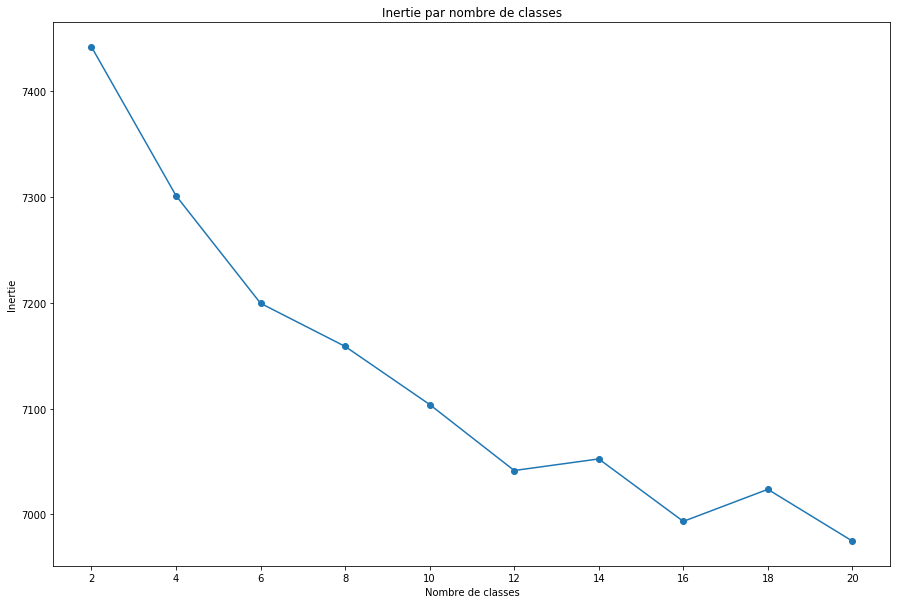

In [12]:
find_optimal_clusters(DataFrame_TFIDF,20)

### Application

Cumulative variance explained by 50  principal components: 0.20375983588137198


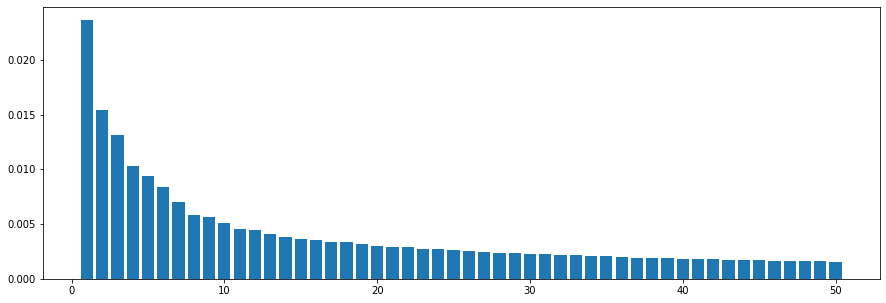

In [13]:
pca, tsne = functions.calcul_acp_tsne(DataFrame_TFIDF)

In [14]:
km = MiniBatchKMeans(n_clusters=9,  random_state=10)
km.fit(DataFrame_TFIDF)
clusters = km.labels_.tolist() 

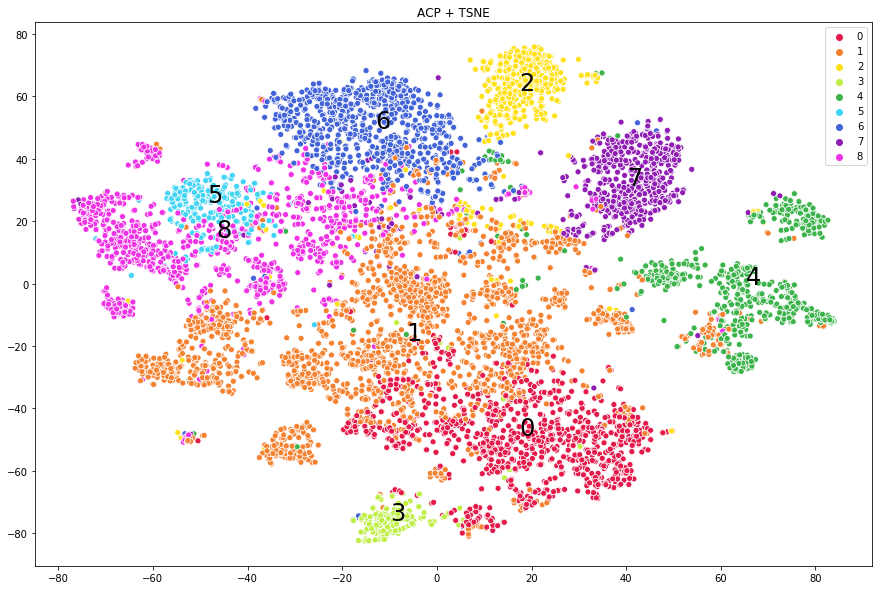

In [15]:
functions.representation_acp_tsne(tsne,pca, size_plot_tsne = (15,10), clusters= clusters, colors = colors[0:9])

In [16]:
top_mots_centroides(DataFrame_TFIDF,km,15)

Top mots proches des centroides:


,classe,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10,term11,term12,term13,term14,term15
0,0,risk,financial,market,office,fund,finance,credit,analyst,derivative,accounting,bank,equity,asset,product,functional
1,1,manager,test,functional,customer,support,analyst,consultant,accounting,monitoring,process,service,specification,production,office,environment
2,2,net,c,sql,asp,server,visual,studio,environment,developer,web,design,software,microsoft,framework,windows
3,3,calypso,analyst,office,fx,market,financial,senior,derivative,product,murex,accounting,consultant,trade,risk,income
4,4,server,administration,windows,production,environment,backup,linux,network,unix,installation,infrastructure,aix,vmware,support,dba
5,5,symfony,php,web,developer,jquery,php5,mysql,zend,javascript,symfony2,framework,css,environment,design,site
6,6,java,spring,j2ee,hibernate,maven,jee,environment,eclipse,web,design,developer,sql,engineer,junit,server
7,7,data,big,datum,r,python,hadoop,spark,learning,java,machine,hive,university,sql,science,scientist
8,8,developer,web,javascript,js,php,android,css,design,jquery,ios,java,html,mysql,html5,technology


In [17]:
from collections import Counter
def top_mots_classes(matrice, clusters, top=10):
    print("Top mots dans les cv:")
    nom_col = ['classe','nb_CV']
    nom_col.extend(["term"+ str(j+1) for j in range(top)])
    
    classes = np.sort(list(Counter(clusters).keys()))
    
    
    result = []
    for c in classes:
        id_CVs_c = [matrice.index[i] for i in range(len(clusters)) if clusters[i]==c]
        result_c = [c, len(id_CVs_c)] 
        
        sub_df_count_c = matrice.loc[id_CVs_c]
        result_c.extend(list(sub_df_count_c.sum(axis=0).sort_values(ascending=False).head(top).index))
        result.append(result_c)
    resume_cluster = pd.DataFrame(result, columns= nom_col)
    return resume_cluster

In [18]:
top_mots_classes(DataFrame_Count, clusters, top=15)

Top mots dans les cv:


,classe,nb_CV,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10,term11,term12,term13,term14,term15
0,0,1200,risk,financial,office,market,functional,manager,support,finance,accounting,tool,bank,credit,control,process,customer
1,1,2467,test,manager,functional,customer,support,service,environment,tool,new,design,process,software,sql,specification,production
2,2,497,net,sql,c,server,environment,design,asp,web,visual,studio,developer,software,tool,windows,framework
3,3,177,calypso,office,analyst,product,market,support,trade,work,fx,financial,functional,accounting,user,consultant,risk
4,4,772,server,environment,windows,production,administration,sql,database,support,network,linux,unix,installation,migration,engineer,backup
5,5,286,php,web,developer,mysql,symfony,jquery,environment,javascript,design,site,css,framework,html,integration,php5
6,6,907,java,spring,j2ee,design,environment,web,sql,service,hibernate,server,developer,eclipse,engineer,test,maven
7,7,641,data,datum,big,r,java,sql,python,hadoop,design,spark,environment,tool,engineer,university,machine
8,8,1139,web,developer,design,javascript,php,java,js,technology,android,css,html,jquery,mysql,c,computer


In [19]:
sortie = top_mots_classes(DataFrame_Count, clusters, top=10)
sortie.insert(2, 'Métier', ["Analyste risque/finance", "Manager", "Développeur Full-Stack", "Analyste risque/finance?", "Système informatique/database", "Développeur Front-end", "Développeur Back-end", "Data engineer", "Développeur Front-end Mobile" ])
sortie

Top mots dans les cv:


,classe,nb_CV,Métier,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10
0,0,1200,Analyste risque/finance,risk,financial,office,market,functional,manager,support,finance,accounting,tool
1,1,2467,Manager,test,manager,functional,customer,support,service,environment,tool,new,design
2,2,497,Développeur Full-Stack,net,sql,c,server,environment,design,asp,web,visual,studio
3,3,177,Analyste risque/finance?,calypso,office,analyst,product,market,support,trade,work,fx,financial
4,4,772,Système informatique/database,server,environment,windows,production,administration,sql,database,support,network,linux
5,5,286,Développeur Front-end,php,web,developer,mysql,symfony,jquery,environment,javascript,design,site
6,6,907,Développeur Back-end,java,spring,j2ee,design,environment,web,sql,service,hibernate,server
7,7,641,Data engineer,data,datum,big,r,java,sql,python,hadoop,design,spark
8,8,1139,Développeur Front-end Mobile,web,developer,design,javascript,php,java,js,technology,android,css


### word count

In [20]:
from collections import Counter
matrice = DataFrame_Count
top =10
nom_col = ['classe','nb_CV']
nom_col.extend(["term"+ str(j+1) for j in range(top)])

classes = np.sort(list(Counter(clusters).keys()))

result = {}
result2 = []
word_count_all = matrice.sum(axis=0)
print(word_count_all['test'])
for c in classes:
    id_CVs_c = [matrice.index[i] for i in range(len(clusters)) if clusters[i]==c]
    sub_df_count_c = matrice.loc[id_CVs_c]
    top_word_c = list(sub_df_count_c.sum(axis=0).sort_values(ascending=False).head(top).index)
    word_countC_countALL = [[word,sub_df_count_c.sum(axis=0)[word], word_count_all[word] ] for word in top_word_c]
    
    result[c] = word_countC_countALL
    result2.extend([[word, c, sub_df_count_c.sum(axis=0)[word], word_count_all[word] ] for word in top_word_c])

df = pd.DataFrame(result2, columns=['word', 'classe', 'count_classe', 'count_all']) 

17721


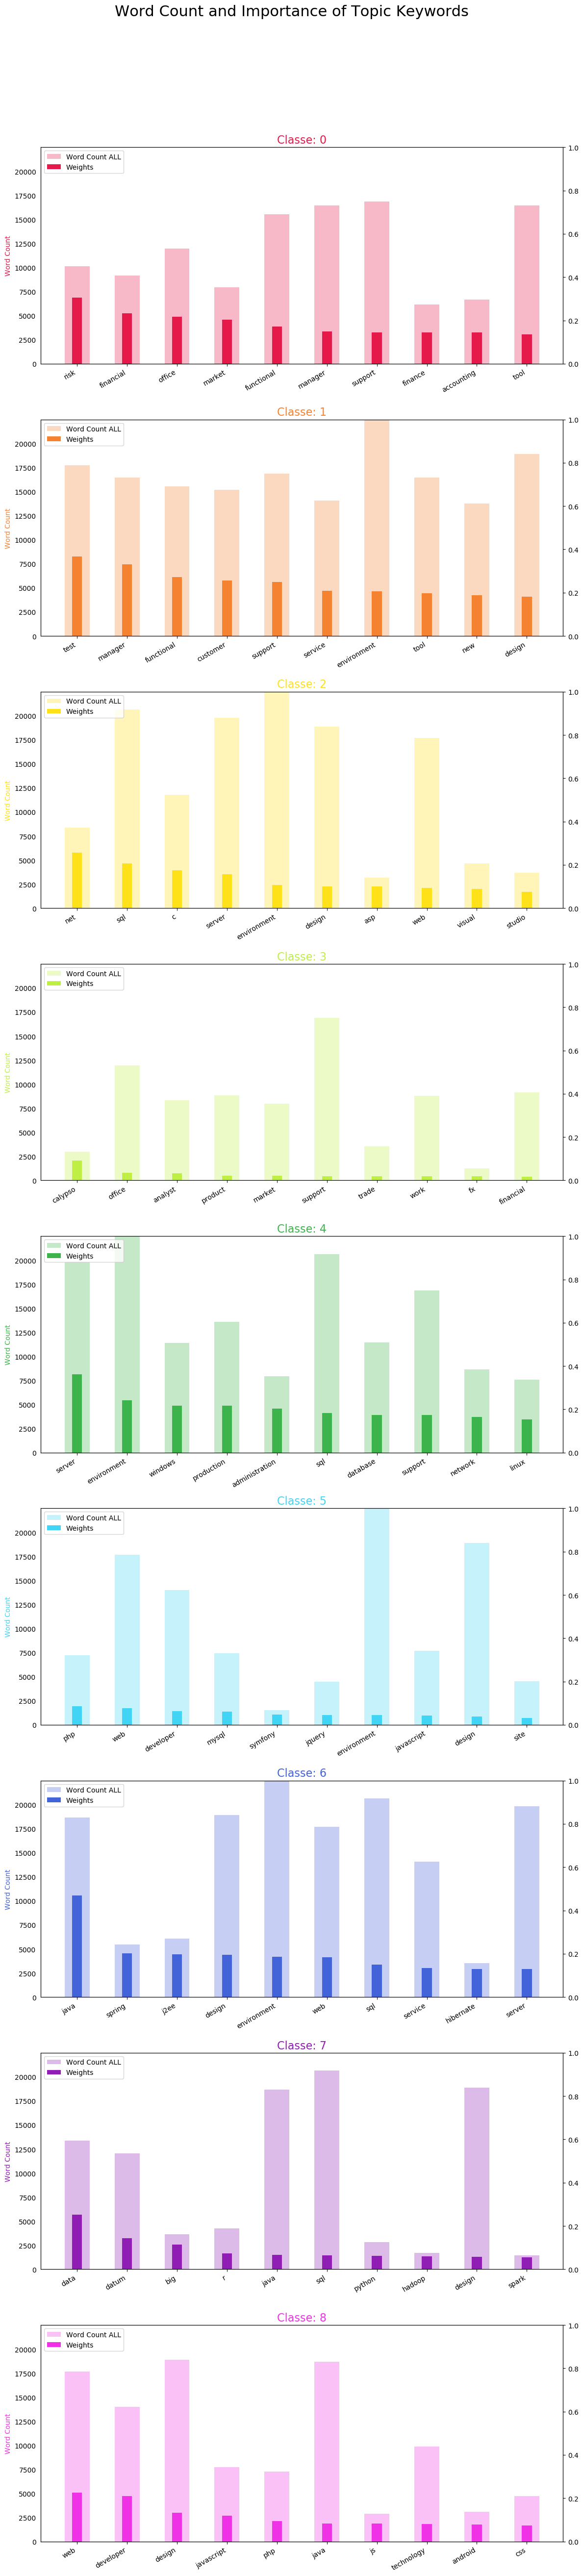

In [21]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(len(classes),1, figsize=(12,50), dpi=100)
cols = colors
for i, ax in enumerate(axes.flatten()):
    data=df.loc[df.classe==i, :]
   
    ax.bar(x='word', height="count_all", data=data, color=cols[i], width=0.5, alpha=0.3, label='Word Count ALL')
    ax_twin = ax.twinx()
    ax.bar(x='word', height="count_classe", data=data, color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_ylim(0, 0.090); ax.set_ylim(0, np.max(df['count_all']))
    ax.set_title('Classe: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### part de CV

In [24]:
from collections import Counter
matrice = DataFrame_Count
top =10
nom_col = ['classe','nb_CV']
nom_col.extend(["term"+ str(j+1) for j in range(top)])

classes = np.sort(list(Counter(clusters).keys()))

result2 = []
nb_CV_mot_all = matrice.astype('bool').sum(axis=0)

for c in classes:
    id_CVs_c = [matrice.index[i] for i in range(len(clusters)) if clusters[i]==c]
    sub_df_count_c = matrice.loc[id_CVs_c]
    nb_CV_mot_c= sub_df_count_c.astype('bool').sum(axis=0)
    pct_CV_mot_c= nb_CV_mot_c / nb_CV_mot_all *100
    top_word_c = list(sub_df_count_c.sum(axis=0).sort_values(ascending=False).head(top).index)
    
    result2.extend([[word, c, pct_CV_mot_c[word] ] for word in top_word_c])

df = pd.DataFrame(result2, columns=['word', 'classe', 'pct_cv_classe']) 

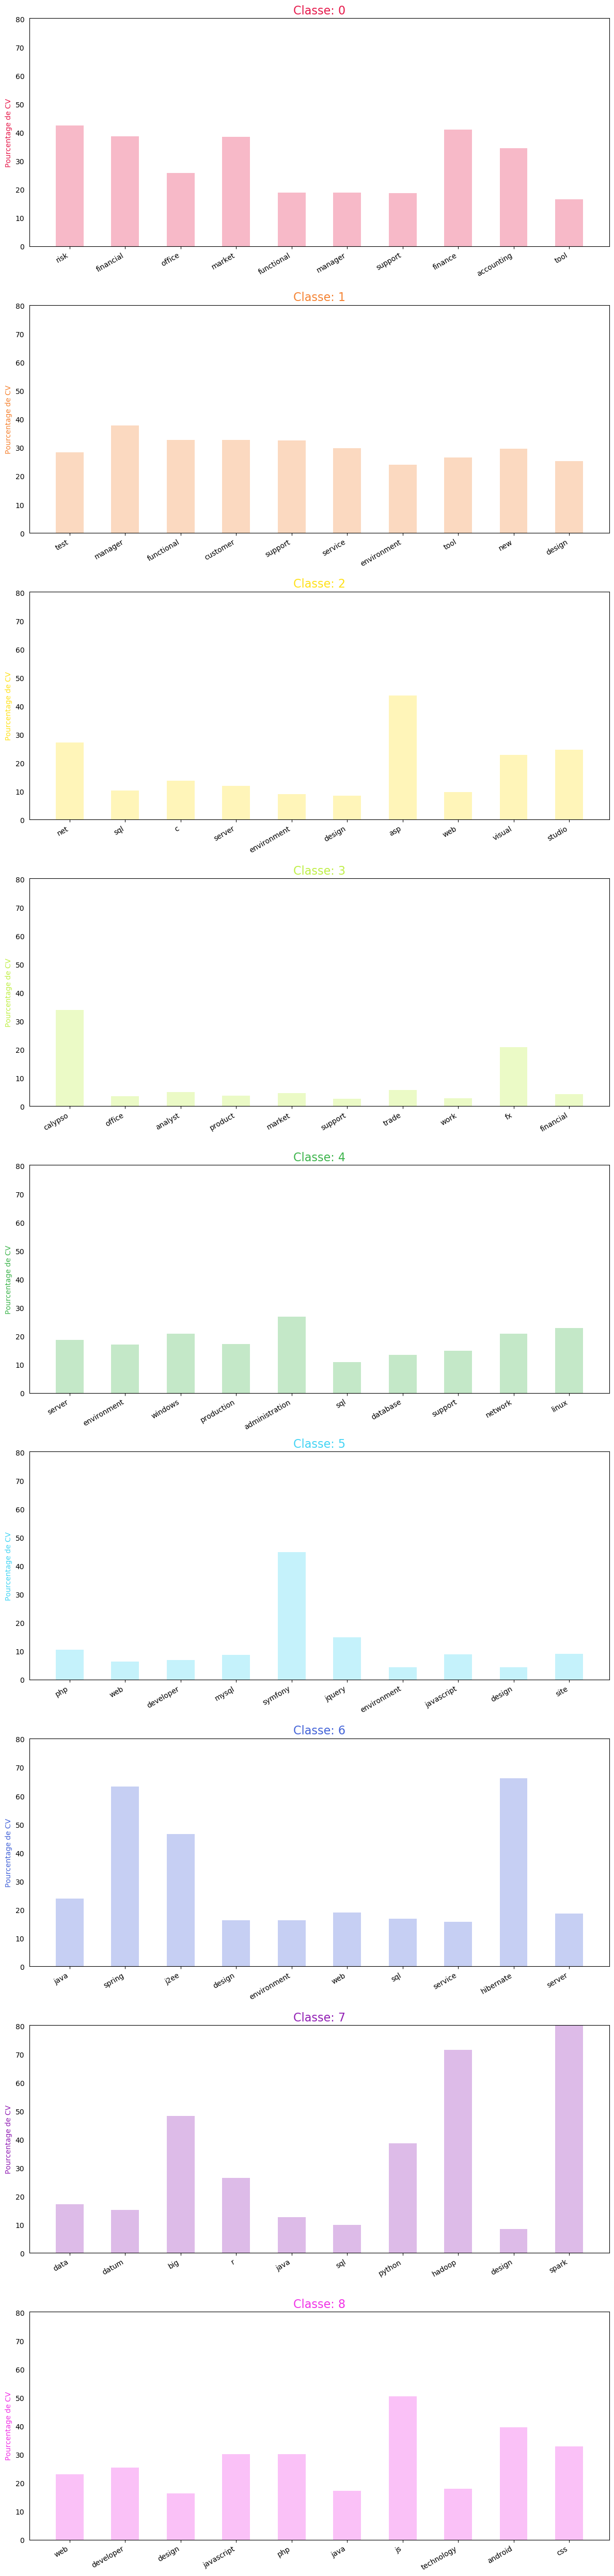

In [27]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(len(classes),1, figsize=(12,50), dpi=100)
cols = colors
for i, ax in enumerate(axes.flatten()):
    data=df.loc[df.classe==i, :]
   
    ax.bar(x='word', height="pct_cv_classe", data=data, color=cols[i], width=0.5, alpha=0.3)
    #ax_twin = ax.twinx()
    #ax.bar(x='word', height="nb_cv_classe", data=data, color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Pourcentage de CV', color=cols[i])
    ax.set_ylim(0, 0.090); ax.set_ylim(0, np.max(df['pct_cv_classe']))
    ax.set_title('Classe: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data['word'], rotation=30, horizontalalignment= 'right')
    
    
fig.tight_layout(w_pad=2)      
plt.show()

In [29]:
with gzip.open('Modele_Kmeans/vectorizerTFIDF.pkl.gz', 'wb') as f:
    pkl.dump(vectorizer, f)

In [30]:
with gzip.open('Modele_Kmeans/modelKmeans.pkl.gz', 'wb') as f:
    pkl.dump(km, f)

# Probabilité d'appartenance

In [31]:
with gzip.open('Modele_Kmeans/vectorizerTFIDF.pkl.gz', 'rb') as f:
        vectorizerTFIDF = pkl.load(f)
with gzip.open('Modele_Kmeans/modelKmeans.pkl.gz', 'rb') as f:
        modelKmeans = pkl.load(f)

In [32]:
vocab = vectorizerTFIDF.get_feature_names()

In [37]:
id_new = DataFrame_TFIDF.index[45]
print("CV numéro " + id_new)
print(modelKmeans.labels_.tolist()[45])

with open('data/'+id_new, 'r') as f:
    new_CV = f.read()
import preprocessing_new_CV

CV numéro 3729
1


In [40]:
new = preprocessing_new_CV.pre_processing(new_CV, vocab=vocab)
new_tfidf = vectorizerTFIDF.transform([" ".join(new)]).toarray()
print(new_tfidf.shape)
print("Classe prédite : " , modelKmeans.predict(new_tfidf))

(1, 12042)
Classe prédite :  [1]
